In [1]:
# Import required libraries
%pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna
import random

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downgrade numpy for TensorFlow compatibility (run this cell and restart kernel)
%pip install numpy==1.26.4
%pip install imblearn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import pandas as pd

# ============================================================
# 1. Global deterministic setup (must be at the very top)
# ============================================================

SEED = 42

# Python & NumPy randomness
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Force single-threaded math libs for determinism
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ============================================================
# 2. Imports (after env vars)
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline

# (Optional) example model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ============================================================
# 3. Load data and define features
# ============================================================

features = [
    'RiskScore', 'MonthlyCharges', 'AvgChargesPerMonth', 'ContractRisk', 'Contract',
    'TotalServices', 'TotalCharges', 'EstimatedCLV', 'HasFamily', 'tenure',
    'Partner', 'HighValueCustomer', 'PaymentRisk', 'Dependents'
]

df = pd.read_csv('final_telco_engineered.csv')

X = df[features]
# Update if your target column has a different name
y = df['Churn']

categorical_cols = ['Contract', 'HasFamily', 'Partner', 'HighValueCustomer', 'Dependents']
numerical_cols = [col for col in features if col not in categorical_cols]

# ============================================================
# 4. Preprocessing pipeline (dense, deterministic)
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        # For newer sklearn: sparse_output=False
        # For older: use sparse=False (you may get a warning on one of them, but it will still work)
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# If you get an error about sparse_output, switch to:
# ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), categorical_cols)

# ============================================================
# 5. Train / val / test split (80 / 10 / 10)
# ============================================================

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1111,   # 0.1111 * 0.90 ≈ 0.10
    random_state=SEED,
    stratify=y_temp
)

# Ensure target variable is numeric (0/1)
if y_train.dtype == 'O' or y_train.dtype.name == 'category':
    y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
    y_val = y_val.map({'No': 0, 'Yes': 1}).astype(int)
    y_test = y_test.map({'No': 0, 'Yes': 1}).astype(int)

# ============================================================
# 6. Fit preprocessor ONLY on training, transform all splits
# ============================================================

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

# Ensure dense float64 (for stable KNN in SMOTE/ENN)
X_train_proc = np.asarray(X_train_proc, dtype=np.float64)
X_val_proc   = np.asarray(X_val_proc,   dtype=np.float64)
X_test_proc  = np.asarray(X_test_proc,  dtype=np.float64)

# ============================================================
# 7. SMOTE + ENN on TRAINING DATA ONLY (deterministic)
# ============================================================

print("Before SMOTE+ENN:")
print(y_train.value_counts())
print("Class distribution:")
print(y_train.value_counts(normalize=True))

# Explicit SMOTE and ENN with fixed random_state
smote = SMOTE(
    random_state=SEED,
    sampling_strategy='auto',  # oversample minority up to majority
    k_neighbors=5
)

enn = EditedNearestNeighbours(
    n_neighbors=3,   # standard ENN
    kind_sel='all'   # deterministic behavior
)

smote_enn = ImbPipeline(steps=[
    ('smote', smote),
    ('enn', enn)
])

X_train_resampled, y_train_resampled = smote_enn.fit_resample(
    X_train_proc,
    y_train
)

print("\nAfter SMOTE+ENN:")
print(y_train_resampled.value_counts())
print("Class distribution:")
print(y_train_resampled.value_counts(normalize=True))

# Use these for training models
X_train_proc = X_train_resampled
y_train      = y_train_resampled

Before SMOTE+ENN:
Churn
0    4138
1    1495
Name: count, dtype: int64
Class distribution:
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64

After SMOTE+ENN:
Churn
0    4138
1    2670
Name: count, dtype: int64
Class distribution:
Churn
0    0.607814
1    0.392186
Name: proportion, dtype: float64


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-11-24 14:27:19,633] A new study created in memory with name: no-name-5268967b-15d0-4d44-a945-125439558fc4
  0%|          | 0/50 [00:00<?, ?it/s]2025-11-24 14:27:19.653804: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-24 14:27:19.653852: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-24 14:27:19.653863: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-24 14:27:19.653884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 14

Early stopping at epoch 16; best val F1=0.6135
Trial early stopped at epoch 16 (best val F1=0.6135)
[I 2025-11-24 14:27:36,580] Trial 0 finished with value: 0.6134663341645885 and parameters: {'n_units': 58, 'lr': 0.007969454818643935, 'dropout': 0.36599697090570255, 'batch_size': 90}. Best is trial 0 with value: 0.6134663341645885.


Best trial: 0. Best value: 0.613466:   4%|▍         | 2/50 [00:25<09:49, 12.28s/it]

Early stopping at epoch 9; best val F1=0.6117
Trial early stopped at epoch 9 (best val F1=0.6117)
[I 2025-11-24 14:27:45,596] Trial 1 finished with value: 0.6117136659436009 and parameters: {'n_units': 33, 'lr': 0.00020511104188433984, 'dropout': 0.02904180608409973, 'batch_size': 116}. Best is trial 0 with value: 0.6134663341645885.


Best trial: 2. Best value: 0.622549:   6%|▌         | 3/50 [00:45<12:07, 15.49s/it]

Early stopping at epoch 22; best val F1=0.6225
Trial early stopped at epoch 22 (best val F1=0.6225)
[I 2025-11-24 14:28:04,903] Trial 2 finished with value: 0.6225490196078431 and parameters: {'n_units': 83, 'lr': 0.0026070247583707684, 'dropout': 0.010292247147901223, 'batch_size': 126}. Best is trial 2 with value: 0.6225490196078431.


Best trial: 2. Best value: 0.622549:   8%|▊         | 4/50 [01:01<12:06, 15.80s/it]

Early stopping at epoch 8; best val F1=0.6015
Trial early stopped at epoch 8 (best val F1=0.6015)
[I 2025-11-24 14:28:21,174] Trial 3 finished with value: 0.6014669926650367 and parameters: {'n_units': 110, 'lr': 0.00026587543983272726, 'dropout': 0.09091248360355031, 'batch_size': 49}. Best is trial 2 with value: 0.6225490196078431.


Best trial: 2. Best value: 0.622549:  10%|█         | 5/50 [01:31<15:43, 20.96s/it]

Early stopping at epoch 17; best val F1=0.6035
Trial early stopped at epoch 17 (best val F1=0.6035)
[I 2025-11-24 14:28:51,292] Trial 4 finished with value: 0.6034912718204489 and parameters: {'n_units': 50, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 2 with value: 0.6225490196078431.


Best trial: 5. Best value: 0.628702:  12%|█▏        | 6/50 [01:43<13:05, 17.85s/it]

Early stopping at epoch 8; best val F1=0.6287
Trial early stopped at epoch 8 (best val F1=0.6287)
[I 2025-11-24 14:29:03,105] Trial 5 finished with value: 0.6287015945330297 and parameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  14%|█▍        | 7/50 [01:57<11:58, 16.70s/it]

Early stopping at epoch 11; best val F1=0.6161
Trial early stopped at epoch 11 (best val F1=0.6161)
[I 2025-11-24 14:29:17,442] Trial 6 finished with value: 0.6161369193154034 and parameters: {'n_units': 67, 'lr': 0.0037183641805732083, 'dropout': 0.09983689107917987, 'batch_size': 81}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  16%|█▌        | 8/50 [02:14<11:39, 16.66s/it]

Early stopping at epoch 9; best val F1=0.6075
Trial early stopped at epoch 9 (best val F1=0.6075)
[I 2025-11-24 14:29:34,015] Trial 7 finished with value: 0.6074766355140186 and parameters: {'n_units': 82, 'lr': 0.0001238513729886094, 'dropout': 0.3037724259507192, 'batch_size': 48}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  18%|█▊        | 9/50 [02:28<10:46, 15.77s/it]

Early stopping at epoch 12; best val F1=0.6050
Trial early stopped at epoch 12 (best val F1=0.6050)
[I 2025-11-24 14:29:47,834] Trial 8 finished with value: 0.605 and parameters: {'n_units': 23, 'lr': 0.007902619549708232, 'dropout': 0.4828160165372797, 'batch_size': 110}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  20%|██        | 10/50 [02:40<09:45, 14.64s/it]

Early stopping at epoch 9; best val F1=0.6031
Trial early stopped at epoch 9 (best val F1=0.6031)
[I 2025-11-24 14:29:59,940] Trial 9 finished with value: 0.6031042128603105 and parameters: {'n_units': 50, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  22%|██▏       | 11/50 [03:18<14:15, 21.93s/it]

Early stopping at epoch 13; best val F1=0.6078
Trial early stopped at epoch 13 (best val F1=0.6078)
[I 2025-11-24 14:30:38,399] Trial 10 finished with value: 0.6078431372549019 and parameters: {'n_units': 124, 'lr': 0.0005338943774556114, 'dropout': 0.18626884362117777, 'batch_size': 33}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  24%|██▍       | 12/50 [03:28<11:28, 18.13s/it]

Early stopping at epoch 8; best val F1=0.6055
Trial early stopped at epoch 8 (best val F1=0.6055)
[I 2025-11-24 14:30:47,824] Trial 11 finished with value: 0.6054590570719603 and parameters: {'n_units': 90, 'lr': 0.0015084240403991644, 'dropout': 0.0045815577638079995, 'batch_size': 126}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  26%|██▌       | 13/50 [03:41<10:12, 16.56s/it]

Early stopping at epoch 8; best val F1=0.6199
Trial early stopped at epoch 8 (best val F1=0.6199)
[I 2025-11-24 14:31:00,785] Trial 12 finished with value: 0.6198547215496368 and parameters: {'n_units': 95, 'lr': 0.002710416521357971, 'dropout': 0.14038047711985213, 'batch_size': 99}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  28%|██▊       | 14/50 [03:52<09:01, 15.04s/it]

Early stopping at epoch 6; best val F1=0.6071
Trial early stopped at epoch 6 (best val F1=0.6071)
[I 2025-11-24 14:31:12,325] Trial 13 finished with value: 0.6070588235294118 and parameters: {'n_units': 103, 'lr': 0.0004903123807866562, 'dropout': 0.06434142014906205, 'batch_size': 71}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  30%|███       | 15/50 [04:03<08:04, 13.85s/it]

Early stopping at epoch 8; best val F1=0.6214
Trial early stopped at epoch 8 (best val F1=0.6214)
[I 2025-11-24 14:31:23,422] Trial 14 finished with value: 0.6213592233009708 and parameters: {'n_units': 78, 'lr': 0.0021002043626702762, 'dropout': 0.15256035042338484, 'batch_size': 95}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  32%|███▏      | 16/50 [04:33<10:37, 18.74s/it]

Early stopping at epoch 17; best val F1=0.6065
Trial early stopped at epoch 17 (best val F1=0.6065)
[I 2025-11-24 14:31:53,521] Trial 15 finished with value: 0.606516290726817 and parameters: {'n_units': 119, 'lr': 0.0004913460742665332, 'dropout': 0.2646549837893469, 'batch_size': 58}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  34%|███▍      | 17/50 [04:44<08:55, 16.24s/it]

Early stopping at epoch 7; best val F1=0.6124
Trial early stopped at epoch 7 (best val F1=0.6124)
[I 2025-11-24 14:32:03,940] Trial 16 finished with value: 0.6124401913875598 and parameters: {'n_units': 71, 'lr': 0.0008488539352123737, 'dropout': 0.004970079125886734, 'batch_size': 128}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  36%|███▌      | 18/50 [05:00<08:38, 16.19s/it]

Early stopping at epoch 13; best val F1=0.6127
Trial early stopped at epoch 13 (best val F1=0.6127)
[I 2025-11-24 14:32:20,017] Trial 17 finished with value: 0.6127450980392157 and parameters: {'n_units': 89, 'lr': 0.003703268825853674, 'dropout': 0.13042253680072105, 'batch_size': 108}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  38%|███▊      | 19/50 [05:10<07:23, 14.32s/it]

Early stopping at epoch 6; best val F1=0.6056
Trial early stopped at epoch 6 (best val F1=0.6056)
[I 2025-11-24 14:32:29,964] Trial 18 finished with value: 0.6056338028169014 and parameters: {'n_units': 108, 'lr': 0.0003041654393076622, 'dropout': 0.05581398126150831, 'batch_size': 87}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  40%|████      | 20/50 [05:32<08:21, 16.73s/it]

Early stopping at epoch 13; best val F1=0.6024
Trial early stopped at epoch 13 (best val F1=0.6024)
[I 2025-11-24 14:32:52,324] Trial 19 finished with value: 0.6023529411764705 and parameters: {'n_units': 64, 'lr': 0.00010617417099250874, 'dropout': 0.2179190079240281, 'batch_size': 66}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  42%|████▏     | 21/50 [06:01<09:47, 20.27s/it]

Early stopping at epoch 12; best val F1=0.6139
Trial early stopped at epoch 12 (best val F1=0.6139)
[I 2025-11-24 14:33:20,829] Trial 20 finished with value: 0.6138613861386139 and parameters: {'n_units': 98, 'lr': 0.004200619720574957, 'dropout': 0.4264342202471388, 'batch_size': 48}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  44%|████▍     | 22/50 [06:12<08:16, 17.73s/it]

Early stopping at epoch 8; best val F1=0.6093
Trial early stopped at epoch 8 (best val F1=0.6093)
[I 2025-11-24 14:33:32,633] Trial 21 finished with value: 0.6093366093366094 and parameters: {'n_units': 80, 'lr': 0.0020799706636213575, 'dropout': 0.16556277843408096, 'batch_size': 98}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  46%|████▌     | 23/50 [06:29<07:50, 17.42s/it]

Early stopping at epoch 13; best val F1=0.6115
Trial early stopped at epoch 13 (best val F1=0.6115)
[I 2025-11-24 14:33:49,355] Trial 22 finished with value: 0.6115288220551378 and parameters: {'n_units': 78, 'lr': 0.0017709002142421758, 'dropout': 0.11604186715251291, 'batch_size': 117}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  48%|████▊     | 24/50 [06:40<06:37, 15.29s/it]

Early stopping at epoch 6; best val F1=0.5951
Trial early stopped at epoch 6 (best val F1=0.5951)
[I 2025-11-24 14:33:59,664] Trial 23 finished with value: 0.5951219512195122 and parameters: {'n_units': 84, 'lr': 0.0008057941097296745, 'dropout': 0.2678401811860963, 'batch_size': 95}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  50%|█████     | 25/50 [07:00<07:01, 16.86s/it]

Early stopping at epoch 13; best val F1=0.6085
Trial early stopped at epoch 13 (best val F1=0.6085)
[I 2025-11-24 14:34:20,198] Trial 24 finished with value: 0.6084788029925187 and parameters: {'n_units': 72, 'lr': 0.001298435574644595, 'dropout': 0.17597937503347055, 'batch_size': 82}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  52%|█████▏    | 26/50 [07:19<07:02, 17.62s/it]

Early stopping at epoch 14; best val F1=0.6247
Trial early stopped at epoch 14 (best val F1=0.6247)
[I 2025-11-24 14:34:39,570] Trial 25 finished with value: 0.6246973365617433 and parameters: {'n_units': 51, 'lr': 0.004929947117800474, 'dropout': 0.05221883299126035, 'batch_size': 103}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  54%|█████▍    | 27/50 [07:34<06:25, 16.76s/it]

Early stopping at epoch 12; best val F1=0.6195
Trial early stopped at epoch 12 (best val F1=0.6195)
[I 2025-11-24 14:34:54,326] Trial 26 finished with value: 0.6195121951219512 and parameters: {'n_units': 39, 'lr': 0.005106892761198581, 'dropout': 0.062124300582986375, 'batch_size': 109}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  56%|█████▌    | 28/50 [07:50<05:59, 16.36s/it]

Early stopping at epoch 14; best val F1=0.6190
Trial early stopped at epoch 14 (best val F1=0.6190)
[I 2025-11-24 14:35:09,749] Trial 27 finished with value: 0.6190476190476191 and parameters: {'n_units': 55, 'lr': 0.006629125146246301, 'dropout': 0.04493290439009024, 'batch_size': 121}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  58%|█████▊    | 29/50 [08:03<05:27, 15.57s/it]

Early stopping at epoch 10; best val F1=0.6143
Trial early stopped at epoch 10 (best val F1=0.6143)
[I 2025-11-24 14:35:23,496] Trial 28 finished with value: 0.6142506142506142 and parameters: {'n_units': 41, 'lr': 0.002724265269977352, 'dropout': 0.08885862040376727, 'batch_size': 104}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  60%|██████    | 30/50 [08:20<05:15, 15.77s/it]

Early stopping at epoch 10; best val F1=0.6180
Trial early stopped at epoch 10 (best val F1=0.6180)
[I 2025-11-24 14:35:39,714] Trial 29 finished with value: 0.6180048661800487 and parameters: {'n_units': 63, 'lr': 0.006007381964750444, 'dropout': 0.02234151196871696, 'batch_size': 87}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  62%|██████▏   | 31/50 [08:33<04:46, 15.07s/it]

Early stopping at epoch 10; best val F1=0.6135
Trial early stopped at epoch 10 (best val F1=0.6135)
[I 2025-11-24 14:35:53,158] Trial 30 finished with value: 0.6135265700483091 and parameters: {'n_units': 56, 'lr': 0.008689713381411777, 'dropout': 0.07979600999590673, 'batch_size': 120}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  64%|██████▍   | 32/50 [08:50<04:43, 15.77s/it]

Early stopping at epoch 9; best val F1=0.6214
Trial early stopped at epoch 9 (best val F1=0.6214)
[I 2025-11-24 14:36:10,556] Trial 31 finished with value: 0.6213592233009708 and parameters: {'n_units': 76, 'lr': 0.0026296753058300992, 'dropout': 0.1336471894371114, 'batch_size': 90}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  66%|██████▌   | 33/50 [09:05<04:23, 15.51s/it]

Early stopping at epoch 8; best val F1=0.6180
Trial early stopped at epoch 8 (best val F1=0.6180)
[I 2025-11-24 14:36:25,466] Trial 32 finished with value: 0.6180048661800487 and parameters: {'n_units': 91, 'lr': 0.002467573240957449, 'dropout': 0.21783843817868376, 'batch_size': 76}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  68%|██████▊   | 34/50 [09:26<04:33, 17.07s/it]

Early stopping at epoch 16; best val F1=0.6235
Trial early stopped at epoch 16 (best val F1=0.6235)
[I 2025-11-24 14:36:46,179] Trial 33 finished with value: 0.6235011990407674 and parameters: {'n_units': 87, 'lr': 0.003632619952842587, 'dropout': 0.03279176711768095, 'batch_size': 102}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  70%|███████   | 35/50 [09:45<04:25, 17.72s/it]

Early stopping at epoch 14; best val F1=0.6199
Trial early stopped at epoch 14 (best val F1=0.6199)
[I 2025-11-24 14:37:05,423] Trial 34 finished with value: 0.6198547215496368 and parameters: {'n_units': 101, 'lr': 0.004422209237791436, 'dropout': 0.030450809669237692, 'batch_size': 103}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  72%|███████▏  | 36/50 [10:08<04:28, 19.15s/it]

Early stopping at epoch 12; best val F1=0.6221
Trial early stopped at epoch 12 (best val F1=0.6221)
[I 2025-11-24 14:37:27,889] Trial 35 finished with value: 0.6221198156682027 and parameters: {'n_units': 26, 'lr': 0.0002867464421202357, 'dropout': 0.10392174158328561, 'batch_size': 62}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  74%|███████▍  | 37/50 [10:28<04:12, 19.45s/it]

Early stopping at epoch 16; best val F1=0.6232
Trial early stopped at epoch 16 (best val F1=0.6232)
[I 2025-11-24 14:37:48,053] Trial 36 finished with value: 0.6231884057971014 and parameters: {'n_units': 112, 'lr': 0.003049590509079017, 'dropout': 0.033020435337470004, 'batch_size': 116}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  76%|███████▌  | 38/50 [10:42<03:32, 17.70s/it]

Early stopping at epoch 8; best val F1=0.6262
Trial early stopped at epoch 8 (best val F1=0.6262)
[I 2025-11-24 14:38:01,678] Trial 37 finished with value: 0.6262135922330098 and parameters: {'n_units': 109, 'lr': 0.0033936214622638933, 'dropout': 0.03896703723140547, 'batch_size': 114}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  78%|███████▊  | 39/50 [10:58<03:10, 17.31s/it]

Early stopping at epoch 11; best val F1=0.6180
Trial early stopped at epoch 11 (best val F1=0.6180)
[I 2025-11-24 14:38:18,060] Trial 38 finished with value: 0.6180048661800487 and parameters: {'n_units': 112, 'lr': 0.00558576063498512, 'dropout': 0.07088013261839907, 'batch_size': 106}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  80%|████████  | 40/50 [11:14<02:48, 16.86s/it]

Early stopping at epoch 6; best val F1=0.6000
Trial early stopped at epoch 6 (best val F1=0.6000)
[I 2025-11-24 14:38:33,875] Trial 39 finished with value: 0.6 and parameters: {'n_units': 125, 'lr': 0.006958572009719218, 'dropout': 0.10566901606323531, 'batch_size': 56}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  82%|████████▏ | 41/50 [11:29<02:27, 16.35s/it]

Early stopping at epoch 9; best val F1=0.6146
Trial early stopped at epoch 9 (best val F1=0.6146)
[I 2025-11-24 14:38:49,038] Trial 40 finished with value: 0.6146341463414634 and parameters: {'n_units': 118, 'lr': 0.003574336444802862, 'dropout': 0.04368060668502671, 'batch_size': 91}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  84%|████████▍ | 42/50 [11:46<02:11, 16.47s/it]

Early stopping at epoch 8; best val F1=0.6180
Trial early stopped at epoch 8 (best val F1=0.6180)
[I 2025-11-24 14:39:05,796] Trial 41 finished with value: 0.6180048661800487 and parameters: {'n_units': 108, 'lr': 0.0031781654489576442, 'dropout': 0.030623692814148187, 'batch_size': 114}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  86%|████████▌ | 43/50 [12:09<02:10, 18.67s/it]

Early stopping at epoch 8; best val F1=0.6055
Trial early stopped at epoch 8 (best val F1=0.6055)
[I 2025-11-24 14:39:29,584] Trial 42 finished with value: 0.6054590570719603 and parameters: {'n_units': 87, 'lr': 0.009439232950168248, 'dropout': 0.009331698755726966, 'batch_size': 113}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  88%|████████▊ | 44/50 [12:25<01:46, 17.79s/it]

Early stopping at epoch 9; best val F1=0.6165
Trial early stopped at epoch 9 (best val F1=0.6165)
[I 2025-11-24 14:39:45,315] Trial 43 finished with value: 0.6164705882352941 and parameters: {'n_units': 115, 'lr': 0.00020805103919744488, 'dropout': 0.043337160120417564, 'batch_size': 121}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  90%|█████████ | 45/50 [12:46<01:33, 18.68s/it]

Early stopping at epoch 13; best val F1=0.6143
Trial early stopped at epoch 13 (best val F1=0.6143)
[I 2025-11-24 14:40:06,085] Trial 44 finished with value: 0.6142506142506142 and parameters: {'n_units': 17, 'lr': 0.005030128599643412, 'dropout': 0.09357098312414536, 'batch_size': 100}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  92%|█████████▏| 46/50 [13:07<01:17, 19.35s/it]

Early stopping at epoch 14; best val F1=0.6115
Trial early stopped at epoch 14 (best val F1=0.6115)
[I 2025-11-24 14:40:26,979] Trial 45 finished with value: 0.6115288220551378 and parameters: {'n_units': 128, 'lr': 0.0015849368625289165, 'dropout': 0.19765610406618742, 'batch_size': 113}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  94%|█████████▍| 47/50 [13:21<00:53, 17.91s/it]

Early stopping at epoch 6; best val F1=0.6091
Trial early stopped at epoch 6 (best val F1=0.6091)
[I 2025-11-24 14:40:41,553] Trial 46 finished with value: 0.6091127098321343 and parameters: {'n_units': 94, 'lr': 0.0010463438719571132, 'dropout': 0.07743213295937339, 'batch_size': 123}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  96%|█████████▌| 48/50 [13:38<00:35, 17.56s/it]

Early stopping at epoch 8; best val F1=0.6250
Trial early stopped at epoch 8 (best val F1=0.6250)
[I 2025-11-24 14:40:58,275] Trial 47 finished with value: 0.625 and parameters: {'n_units': 103, 'lr': 0.003263239043838548, 'dropout': 0.0018084531151905878, 'batch_size': 116}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702:  98%|█████████▊| 49/50 [14:05<00:20, 20.26s/it]

Early stopping at epoch 13; best val F1=0.6085
Trial early stopped at epoch 13 (best val F1=0.6085)
[I 2025-11-24 14:41:24,850] Trial 48 finished with value: 0.6084788029925187 and parameters: {'n_units': 103, 'lr': 0.0006382308048043262, 'dropout': 0.0030740722047355555, 'batch_size': 68}. Best is trial 5 with value: 0.6287015945330297.


Best trial: 5. Best value: 0.628702: 100%|██████████| 50/50 [14:30<00:00, 17.41s/it]

Early stopping at epoch 12; best val F1=0.6176
Trial early stopped at epoch 12 (best val F1=0.6176)
[I 2025-11-24 14:41:50,235] Trial 49 finished with value: 0.6176470588235294 and parameters: {'n_units': 96, 'lr': 0.0020387117163173808, 'dropout': 0.3466579974593711, 'batch_size': 78}. Best is trial 5 with value: 0.6287015945330297.
Best FNN hyperparameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}


Early stopping at epoch 7; best val F1=0.6057
Final FNN early stopped at epoch 7 (best val F1=0.6057)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FNN Test Results:
Accuracy: 0.7461
F1 Score: 0.6066
Precision: 0.5149
Recall (Sensitivity): 0.7380
Specificity: 0.7490
AUC: 0.8181


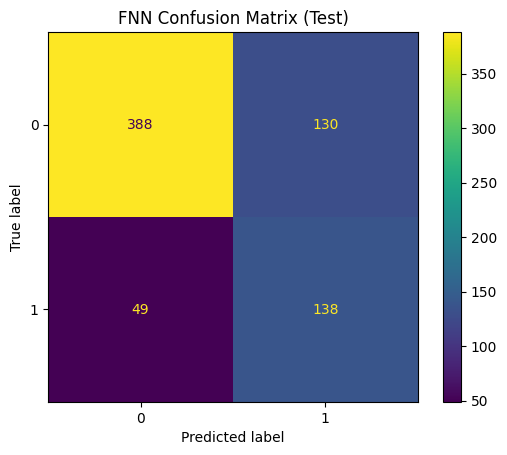

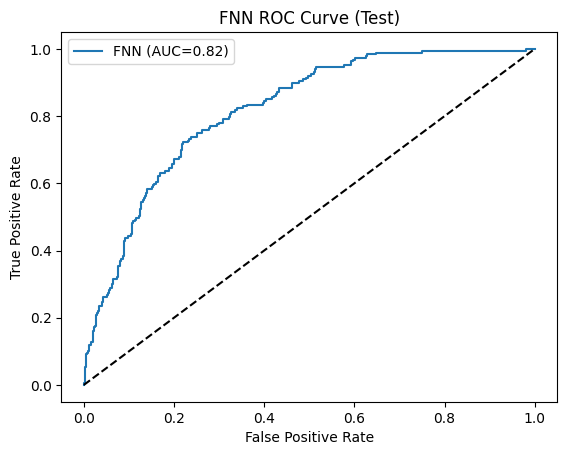

In [4]:
# Feed Forward Neural Network (FNN) with Optuna hyperparameter tuning (F1-based)
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True

def create_fnn_model(trial):
    n_units = trial.suggest_int('n_units', 16, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_fnn(trial):
    model = create_fnn_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_fnn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_fnn.optimize(objective_fnn, n_trials=50, show_progress_bar=True)

best_params_fnn = study_fnn.best_params
print('Best FNN hyperparameters:', best_params_fnn)
best_fnn = create_fnn_model(optuna.trial.FixedTrial(best_params_fnn))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_fnn.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_fnn['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final FNN early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_fnn.set_weights(f1_callback_final.best_weights)

pred_test_fnn = best_fnn.predict(X_test_proc).ravel()
pred_test_label_fnn = (pred_test_fnn > 0.5).astype(int)
cm_fnn = confusion_matrix(y_test, pred_test_label_fnn)
roc_auc_fnn = roc_auc_score(y_test, pred_test_fnn)
f1_fnn = f1_score(y_test, pred_test_label_fnn)
precision_fnn = precision_score(y_test, pred_test_label_fnn)
recall_fnn = recall_score(y_test, pred_test_label_fnn)
specificity_fnn = cm_fnn[0,0] / (cm_fnn[0,0] + cm_fnn[0,1]) if (cm_fnn[0,0] + cm_fnn[0,1]) > 0 else 0
accuracy_fnn = (cm_fnn[0,0] + cm_fnn[1,1]) / cm_fnn.sum()
print('FNN Test Results:')
print(f'Accuracy: {accuracy_fnn:.4f}')
print(f'F1 Score: {f1_fnn:.4f}')
print(f'Precision: {precision_fnn:.4f}')
print(f'Recall (Sensitivity): {recall_fnn:.4f}')
print(f'Specificity: {specificity_fnn:.4f}')
print(f'AUC: {roc_auc_fnn:.4f}')
ConfusionMatrixDisplay(cm_fnn).plot()
plt.title('FNN Confusion Matrix (Test)')
plt.show()
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, pred_test_fnn)
plt.figure()
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC={roc_auc_fnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNN ROC Curve (Test)')
plt.legend()
plt.show()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-11-24 14:54:23,991] A new study created in memory with name: no-name-a033416c-e44d-4091-b3bf-138a73ceb402
  0%|          | 0/50 [00:00<?, ?it/s]2025-11-24 14:54:24.011224: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-24 14:54:24.011270: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-24 14:54:24.011280: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-24 14:54:24.011299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 14

Early stopping at epoch 13; best val F1=0.6064
Trial early stopped at epoch 13 (best val F1=0.6064)
[I 2025-11-24 14:54:56,618] Trial 0 finished with value: 0.6063829787234043 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0029106359131330704, 'dropout': 0.2993292420985183, 'batch_size': 47}. Best is trial 0 with value: 0.6063829787234043.


Best trial: 1. Best value: 0.609302:   4%|▍         | 2/50 [00:42<15:14, 19.06s/it]

Early stopping at epoch 7; best val F1=0.6093
Trial early stopped at epoch 7 (best val F1=0.6093)
[I 2025-11-24 14:55:06,184] Trial 1 finished with value: 0.6093023255813953 and parameters: {'n_layers': 2, 'n_units': 37, 'lr': 0.005399484409787433, 'dropout': 0.3005575058716044, 'batch_size': 100}. Best is trial 1 with value: 0.6093023255813953.


Best trial: 2. Best value: 0.655:   6%|▌         | 3/50 [01:03<15:54, 20.31s/it]   

Early stopping at epoch 10; best val F1=0.6550
Trial early stopped at epoch 10 (best val F1=0.6550)
[I 2025-11-24 14:55:27,976] Trial 2 finished with value: 0.655 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:   8%|▊         | 4/50 [01:21<14:52, 19.40s/it]

Early stopping at epoch 8; best val F1=0.6135
Trial early stopped at epoch 8 (best val F1=0.6135)
[I 2025-11-24 14:55:45,992] Trial 3 finished with value: 0.6135265700483091 and parameters: {'n_layers': 2, 'n_units': 61, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  10%|█         | 5/50 [01:36<13:06, 17.47s/it]

Early stopping at epoch 6; best val F1=0.6146
Trial early stopped at epoch 6 (best val F1=0.6146)
[I 2025-11-24 14:56:00,050] Trial 4 finished with value: 0.6146341463414634 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.0003839629299804173, 'dropout': 0.18318092164684585, 'batch_size': 76}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  12%|█▏        | 6/50 [02:34<23:07, 31.54s/it]

Early stopping at epoch 13; best val F1=0.6326
Trial early stopped at epoch 13 (best val F1=0.6326)
[I 2025-11-24 14:56:58,881] Trial 5 finished with value: 0.6325581395348837 and parameters: {'n_layers': 4, 'n_units': 51, 'lr': 0.0010677482709481358, 'dropout': 0.29620728443102123, 'batch_size': 36}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  14%|█▍        | 7/50 [02:50<18:54, 26.39s/it]

Early stopping at epoch 10; best val F1=0.6161
Trial early stopped at epoch 10 (best val F1=0.6161)
[I 2025-11-24 14:57:14,680] Trial 6 finished with value: 0.6160919540229886 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00013492834268013249, 'dropout': 0.4744427686266666, 'batch_size': 125}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  16%|█▌        | 8/50 [03:18<18:46, 26.82s/it]

Early stopping at epoch 11; best val F1=0.6127
Trial early stopped at epoch 11 (best val F1=0.6127)
[I 2025-11-24 14:57:42,403] Trial 7 finished with value: 0.6127450980392157 and parameters: {'n_layers': 4, 'n_units': 61, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  18%|█▊        | 9/50 [03:33<15:53, 23.25s/it]

Early stopping at epoch 7; best val F1=0.5972
Trial early stopped at epoch 7 (best val F1=0.5972)
[I 2025-11-24 14:57:57,817] Trial 8 finished with value: 0.5972222222222222 and parameters: {'n_layers': 2, 'n_units': 80, 'lr': 0.00011715937392307068, 'dropout': 0.45466020103939103, 'batch_size': 57}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  20%|██        | 10/50 [03:52<14:33, 21.83s/it]

Early stopping at epoch 6; best val F1=0.5922
Trial early stopped at epoch 6 (best val F1=0.5922)
[I 2025-11-24 14:58:16,468] Trial 9 finished with value: 0.5922330097087378 and parameters: {'n_layers': 3, 'n_units': 62, 'lr': 0.001096821720752952, 'dropout': 0.2733551396716398, 'batch_size': 49}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  22%|██▏       | 11/50 [04:04<12:13, 18.80s/it]

Early stopping at epoch 7; best val F1=0.6256
Trial early stopped at epoch 7 (best val F1=0.6256)
[I 2025-11-24 14:58:28,380] Trial 10 finished with value: 0.625615763546798 and parameters: {'n_layers': 2, 'n_units': 122, 'lr': 0.008691089486124988, 'dropout': 0.014802708511848103, 'batch_size': 95}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  24%|██▍       | 12/50 [04:33<13:54, 21.95s/it]

Early stopping at epoch 6; best val F1=0.6004
Trial early stopped at epoch 6 (best val F1=0.6004)
[I 2025-11-24 14:58:57,554] Trial 11 finished with value: 0.6004319654427646 and parameters: {'n_layers': 4, 'n_units': 105, 'lr': 0.0030043648533792707, 'dropout': 0.09716035966917078, 'batch_size': 32}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  26%|██▌       | 13/50 [05:04<15:09, 24.58s/it]

Early stopping at epoch 6; best val F1=0.6150
Trial early stopped at epoch 6 (best val F1=0.6150)
[I 2025-11-24 14:59:28,164] Trial 12 finished with value: 0.6150121065375302 and parameters: {'n_layers': 4, 'n_units': 93, 'lr': 0.0004902996090510051, 'dropout': 0.12905147570373954, 'batch_size': 33}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  28%|██▊       | 14/50 [05:31<15:13, 25.38s/it]

Early stopping at epoch 6; best val F1=0.6000
Trial early stopped at epoch 6 (best val F1=0.6000)
[I 2025-11-24 14:59:55,400] Trial 13 finished with value: 0.6 and parameters: {'n_layers': 4, 'n_units': 85, 'lr': 0.0020823248971386394, 'dropout': 0.004664033111184768, 'batch_size': 41}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  30%|███       | 15/50 [06:05<16:19, 27.98s/it]

Early stopping at epoch 15; best val F1=0.5951
Trial early stopped at epoch 15 (best val F1=0.5951)
[I 2025-11-24 15:00:29,399] Trial 14 finished with value: 0.5951219512195122 and parameters: {'n_layers': 3, 'n_units': 108, 'lr': 0.0006373761191045682, 'dropout': 0.3947385331597324, 'batch_size': 63}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  32%|███▏      | 16/50 [06:24<14:18, 25.24s/it]

Early stopping at epoch 7; best val F1=0.6085
Trial early stopped at epoch 7 (best val F1=0.6085)
[I 2025-11-24 15:00:48,276] Trial 15 finished with value: 0.608534322820037 and parameters: {'n_layers': 4, 'n_units': 73, 'lr': 0.009818226878189128, 'dropout': 0.13452039406810484, 'batch_size': 96}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  34%|███▍      | 17/50 [06:49<13:56, 25.33s/it]

Early stopping at epoch 8; best val F1=0.6025
Trial early stopped at epoch 8 (best val F1=0.6025)
[I 2025-11-24 15:01:13,831] Trial 16 finished with value: 0.6024691358024692 and parameters: {'n_layers': 2, 'n_units': 32, 'lr': 0.001825716150969893, 'dropout': 0.06384067745271635, 'batch_size': 42}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  36%|███▌      | 18/50 [07:18<13:58, 26.21s/it]

Early stopping at epoch 12; best val F1=0.5941
Trial early stopped at epoch 12 (best val F1=0.5941)
[I 2025-11-24 15:01:42,098] Trial 17 finished with value: 0.594059405940594 and parameters: {'n_layers': 3, 'n_units': 102, 'lr': 0.0002674701807186936, 'dropout': 0.2102776469499485, 'batch_size': 68}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  38%|███▊      | 19/50 [07:42<13:14, 25.64s/it]

Early stopping at epoch 10; best val F1=0.6205
Trial early stopped at epoch 10 (best val F1=0.6205)
[I 2025-11-24 15:02:06,385] Trial 18 finished with value: 0.6205250596658711 and parameters: {'n_layers': 4, 'n_units': 114, 'lr': 0.005078516654170437, 'dropout': 0.3760009506200636, 'batch_size': 88}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  40%|████      | 20/50 [08:14<13:51, 27.72s/it]

Early stopping at epoch 13; best val F1=0.6111
Trial early stopped at epoch 13 (best val F1=0.6111)
[I 2025-11-24 15:02:38,964] Trial 19 finished with value: 0.6111111111111112 and parameters: {'n_layers': 2, 'n_units': 94, 'lr': 0.00150548027361504, 'dropout': 0.1787709968782899, 'batch_size': 53}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  42%|████▏     | 21/50 [08:41<13:13, 27.35s/it]

Early stopping at epoch 17; best val F1=0.6072
Trial early stopped at epoch 17 (best val F1=0.6072)
[I 2025-11-24 15:03:05,435] Trial 20 finished with value: 0.6072289156626506 and parameters: {'n_layers': 3, 'n_units': 72, 'lr': 0.0006564969085812728, 'dropout': 0.25294027235750977, 'batch_size': 108}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  44%|████▍     | 22/50 [08:57<11:08, 23.87s/it]

Early stopping at epoch 8; best val F1=0.6320
Trial early stopped at epoch 8 (best val F1=0.6320)
[I 2025-11-24 15:03:21,197] Trial 21 finished with value: 0.632016632016632 and parameters: {'n_layers': 2, 'n_units': 123, 'lr': 0.009757240764024289, 'dropout': 0.015741373831806155, 'batch_size': 87}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  46%|████▌     | 23/50 [09:21<10:48, 24.03s/it]

Early stopping at epoch 12; best val F1=0.6150
Trial early stopped at epoch 12 (best val F1=0.6150)
[I 2025-11-24 15:03:45,603] Trial 22 finished with value: 0.6149584487534626 and parameters: {'n_layers': 2, 'n_units': 128, 'lr': 0.005749666155131858, 'dropout': 0.048932424403376085, 'batch_size': 79}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  48%|████▊     | 24/50 [09:35<09:06, 21.02s/it]

Early stopping at epoch 6; best val F1=0.6100
Trial early stopped at epoch 6 (best val F1=0.6100)
[I 2025-11-24 15:03:59,601] Trial 23 finished with value: 0.61 and parameters: {'n_layers': 2, 'n_units': 120, 'lr': 0.003518879377451811, 'dropout': 0.0645730342149979, 'batch_size': 87}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  50%|█████     | 25/50 [09:54<08:32, 20.50s/it]

Early stopping at epoch 11; best val F1=0.6137
Trial early stopped at epoch 11 (best val F1=0.6137)
[I 2025-11-24 15:04:18,884] Trial 24 finished with value: 0.6136865342163356 and parameters: {'n_layers': 2, 'n_units': 113, 'lr': 0.007211137594701159, 'dropout': 0.132035183231185, 'batch_size': 117}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  52%|█████▏    | 26/50 [10:51<12:28, 31.19s/it]

Early stopping at epoch 14; best val F1=0.6160
Trial early stopped at epoch 14 (best val F1=0.6160)
[I 2025-11-24 15:05:15,021] Trial 25 finished with value: 0.6160164271047228 and parameters: {'n_layers': 3, 'n_units': 53, 'lr': 0.004350026387363677, 'dropout': 0.0387367792758523, 'batch_size': 40}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  54%|█████▍    | 27/50 [11:15<11:08, 29.05s/it]

Early stopping at epoch 9; best val F1=0.6434
Trial early stopped at epoch 9 (best val F1=0.6434)
[I 2025-11-24 15:05:39,072] Trial 26 finished with value: 0.6433915211970075 and parameters: {'n_layers': 2, 'n_units': 98, 'lr': 0.006260320009195335, 'dropout': 0.10068181046144145, 'batch_size': 66}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  56%|█████▌    | 28/50 [11:36<09:46, 26.66s/it]

Early stopping at epoch 9; best val F1=0.5983
Trial early stopped at epoch 9 (best val F1=0.5983)
[I 2025-11-24 15:06:00,168] Trial 27 finished with value: 0.5983379501385041 and parameters: {'n_layers': 2, 'n_units': 96, 'lr': 0.002527066432305605, 'dropout': 0.10235907386496851, 'batch_size': 65}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  58%|█████▊    | 29/50 [12:17<10:54, 31.15s/it]

Early stopping at epoch 10; best val F1=0.6022
Trial early stopped at epoch 10 (best val F1=0.6022)
[I 2025-11-24 15:06:41,803] Trial 28 finished with value: 0.6022471910112359 and parameters: {'n_layers': 4, 'n_units': 85, 'lr': 0.003912541234694179, 'dropout': 0.1728753734253724, 'batch_size': 53}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  60%|██████    | 30/50 [12:43<09:50, 29.52s/it]

Early stopping at epoch 6; best val F1=0.6169
Trial early stopped at epoch 6 (best val F1=0.6169)
[I 2025-11-24 15:07:07,514] Trial 29 finished with value: 0.6168674698795181 and parameters: {'n_layers': 3, 'n_units': 69, 'lr': 0.006844013303515744, 'dropout': 0.3238783351338898, 'batch_size': 45}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  62%|██████▏   | 31/50 [13:08<08:55, 28.20s/it]

Early stopping at epoch 13; best val F1=0.6131
Trial early stopped at epoch 13 (best val F1=0.6131)
[I 2025-11-24 15:07:32,625] Trial 30 finished with value: 0.6131386861313869 and parameters: {'n_layers': 2, 'n_units': 100, 'lr': 0.0008438966775953441, 'dropout': 0.22815150302874465, 'batch_size': 70}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  64%|██████▍   | 32/50 [13:26<07:34, 25.24s/it]

Early stopping at epoch 9; best val F1=0.6260
Trial early stopped at epoch 9 (best val F1=0.6260)
[I 2025-11-24 15:07:50,959] Trial 31 finished with value: 0.6259946949602122 and parameters: {'n_layers': 2, 'n_units': 116, 'lr': 0.009562546296413578, 'dropout': 0.09425729153651549, 'batch_size': 84}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  66%|██████▌   | 33/50 [13:58<07:39, 27.03s/it]

Early stopping at epoch 11; best val F1=0.6280
Trial early stopped at epoch 11 (best val F1=0.6280)
[I 2025-11-24 15:08:22,158] Trial 32 finished with value: 0.6279683377308707 and parameters: {'n_layers': 2, 'n_units': 127, 'lr': 0.006092844598662555, 'dropout': 0.032781204736707405, 'batch_size': 37}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  68%|██████▊   | 34/50 [14:34<07:59, 29.95s/it]

Early stopping at epoch 18; best val F1=0.6168
Trial early stopped at epoch 18 (best val F1=0.6168)
[I 2025-11-24 15:08:58,943] Trial 33 finished with value: 0.616822429906542 and parameters: {'n_layers': 2, 'n_units': 110, 'lr': 0.004656070345430673, 'dropout': 0.2756665118295437, 'batch_size': 58}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  70%|███████   | 35/50 [14:53<06:39, 26.65s/it]

Early stopping at epoch 6; best val F1=0.6070
Trial early stopped at epoch 6 (best val F1=0.6070)
[I 2025-11-24 15:09:17,880] Trial 34 finished with value: 0.6069651741293532 and parameters: {'n_layers': 2, 'n_units': 120, 'lr': 0.001387808866802901, 'dropout': 0.15067121433745925, 'batch_size': 49}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  72%|███████▏  | 36/50 [15:11<05:36, 24.00s/it]

Early stopping at epoch 6; best val F1=0.5980
Trial early stopped at epoch 6 (best val F1=0.5980)
[I 2025-11-24 15:09:35,706] Trial 35 finished with value: 0.5980392156862745 and parameters: {'n_layers': 2, 'n_units': 120, 'lr': 0.0029568856867061262, 'dropout': 0.08289649737122987, 'batch_size': 103}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  74%|███████▍  | 37/50 [15:34<05:08, 23.75s/it]

Early stopping at epoch 6; best val F1=0.6118
Trial early stopped at epoch 6 (best val F1=0.6118)
[I 2025-11-24 15:09:58,855] Trial 36 finished with value: 0.611764705882353 and parameters: {'n_layers': 3, 'n_units': 46, 'lr': 0.00022076001499514062, 'dropout': 0.005902207171500709, 'batch_size': 77}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  76%|███████▌  | 38/50 [16:05<05:08, 25.68s/it]

Early stopping at epoch 9; best val F1=0.6250
Trial early stopped at epoch 9 (best val F1=0.6250)
[I 2025-11-24 15:10:29,032] Trial 37 finished with value: 0.625 and parameters: {'n_layers': 3, 'n_units': 56, 'lr': 0.008256311660095432, 'dropout': 0.21020925327419196, 'batch_size': 73}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  78%|███████▊  | 39/50 [16:41<05:16, 28.79s/it]

Early stopping at epoch 14; best val F1=0.6158
Trial early stopped at epoch 14 (best val F1=0.6158)
[I 2025-11-24 15:11:05,092] Trial 38 finished with value: 0.6157635467980296 and parameters: {'n_layers': 2, 'n_units': 40, 'lr': 0.006843663143757139, 'dropout': 0.30906140630103834, 'batch_size': 53}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  80%|████████  | 40/50 [17:02<04:26, 26.63s/it]

Early stopping at epoch 7; best val F1=0.6150
Trial early stopped at epoch 7 (best val F1=0.6150)
[I 2025-11-24 15:11:26,690] Trial 39 finished with value: 0.6150121065375302 and parameters: {'n_layers': 2, 'n_units': 79, 'lr': 0.00032397497717200654, 'dropout': 0.36549992821367444, 'batch_size': 61}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  82%|████████▏ | 41/50 [17:26<03:52, 25.87s/it]

Early stopping at epoch 6; best val F1=0.6184
Trial early stopped at epoch 6 (best val F1=0.6184)
[I 2025-11-24 15:11:50,777] Trial 40 finished with value: 0.6183574879227053 and parameters: {'n_layers': 2, 'n_units': 125, 'lr': 0.0036386723368295377, 'dropout': 0.42645427345577225, 'batch_size': 37}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  84%|████████▍ | 42/50 [18:24<04:43, 35.38s/it]

Early stopping at epoch 17; best val F1=0.6348
Trial early stopped at epoch 17 (best val F1=0.6348)
[I 2025-11-24 15:12:48,355] Trial 41 finished with value: 0.6347992351816444 and parameters: {'n_layers': 2, 'n_units': 123, 'lr': 0.00569130805762703, 'dropout': 0.03322669007446956, 'batch_size': 38}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  86%|████████▌ | 43/50 [18:55<03:58, 34.03s/it]

Early stopping at epoch 9; best val F1=0.6294
Trial early stopped at epoch 9 (best val F1=0.6294)
[I 2025-11-24 15:13:19,223] Trial 42 finished with value: 0.6294416243654822 and parameters: {'n_layers': 2, 'n_units': 114, 'lr': 0.0024398020965920677, 'dropout': 0.025234208531302392, 'batch_size': 44}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  88%|████████▊ | 44/50 [19:50<04:01, 40.31s/it]

Early stopping at epoch 16; best val F1=0.6461
Trial early stopped at epoch 16 (best val F1=0.6461)
[I 2025-11-24 15:14:14,206] Trial 43 finished with value: 0.6460807600950119 and parameters: {'n_layers': 2, 'n_units': 123, 'lr': 0.004707913569613634, 'dropout': 0.06546209041317276, 'batch_size': 35}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  90%|█████████ | 45/50 [20:20<03:07, 37.43s/it]

Early stopping at epoch 7; best val F1=0.6158
Trial early stopped at epoch 7 (best val F1=0.6158)
[I 2025-11-24 15:14:44,921] Trial 44 finished with value: 0.6157635467980296 and parameters: {'n_layers': 2, 'n_units': 89, 'lr': 0.003358734129476344, 'dropout': 0.06098057947508703, 'batch_size': 36}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  92%|█████████▏| 46/50 [21:21<02:57, 44.33s/it]

Early stopping at epoch 17; best val F1=0.6345
Trial early stopped at epoch 17 (best val F1=0.6345)
[I 2025-11-24 15:15:45,352] Trial 45 finished with value: 0.634453781512605 and parameters: {'n_layers': 2, 'n_units': 106, 'lr': 0.0051570039387137745, 'dropout': 0.10996597414785382, 'batch_size': 32}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  94%|█████████▍| 47/50 [22:24<02:30, 50.04s/it]

Early stopping at epoch 18; best val F1=0.6402
Trial early stopped at epoch 18 (best val F1=0.6402)
[I 2025-11-24 15:16:48,695] Trial 46 finished with value: 0.6401985111662531 and parameters: {'n_layers': 2, 'n_units': 104, 'lr': 0.005978829072426453, 'dropout': 0.11767157063815291, 'batch_size': 32}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  96%|█████████▌| 48/50 [22:49<01:24, 42.33s/it]

Early stopping at epoch 6; best val F1=0.6261
Trial early stopped at epoch 6 (best val F1=0.6261)
[I 2025-11-24 15:17:13,031] Trial 47 finished with value: 0.6261261261261262 and parameters: {'n_layers': 2, 'n_units': 100, 'lr': 0.007382680963846299, 'dropout': 0.07451560419964023, 'batch_size': 49}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655:  98%|█████████▊| 49/50 [23:23<00:39, 39.88s/it]

Early stopping at epoch 9; best val F1=0.6224
Trial early stopped at epoch 9 (best val F1=0.6224)
[I 2025-11-24 15:17:47,209] Trial 48 finished with value: 0.6224256292906178 and parameters: {'n_layers': 2, 'n_units': 118, 'lr': 0.004440995941068278, 'dropout': 0.1562142052506187, 'batch_size': 45}. Best is trial 2 with value: 0.655.


Best trial: 2. Best value: 0.655: 100%|██████████| 50/50 [24:36<00:00, 29.53s/it]

Early stopping at epoch 17; best val F1=0.6346
Trial early stopped at epoch 17 (best val F1=0.6346)
[I 2025-11-24 15:19:00,721] Trial 49 finished with value: 0.6345733041575492 and parameters: {'n_layers': 2, 'n_units': 110, 'lr': 0.005885924315063567, 'dropout': 0.12352348802849519, 'batch_size': 40}. Best is trial 2 with value: 0.655.
Best MLP hyperparameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}


Early stopping at epoch 6; best val F1=0.6244
Final MLP early stopped at epoch 6 (best val F1=0.6244)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MLP Test Results:
Accuracy: 0.7716
F1 Score: 0.6176
Precision: 0.5556
Recall (Sensitivity): 0.6952
Specificity: 0.7992
AUC: 0.8337


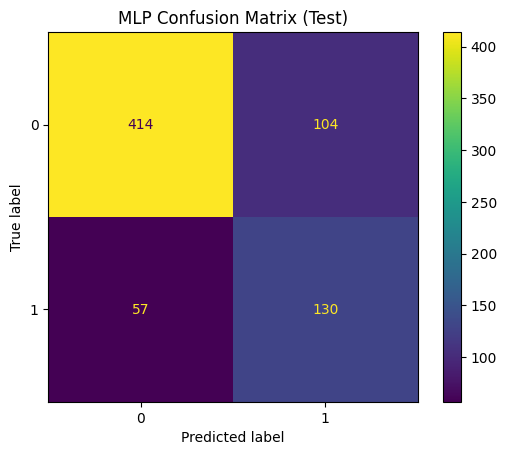

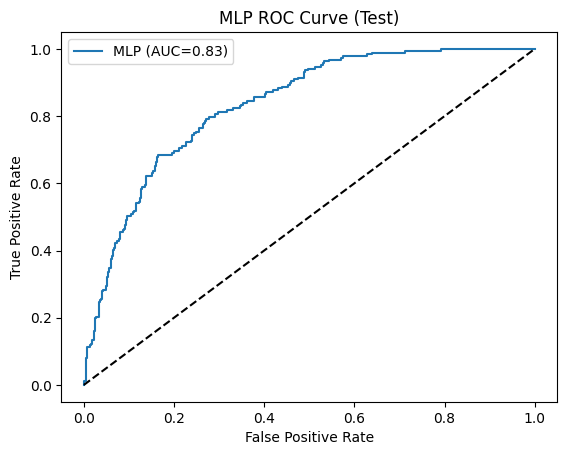

In [4]:
# Multi-Layer Perceptron (MLP) with Optuna hyperparameter tuning (F1-based)
# F1EarlyStopping already defined above; class weights removed
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True
            
def create_mlp_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_proc.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_mlp(trial):
    model = create_mlp_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)

best_params_mlp = study_mlp.best_params
print('Best MLP hyperparameters:', best_params_mlp)
best_mlp = create_mlp_model(optuna.trial.FixedTrial(best_params_mlp))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_mlp.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_mlp['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final MLP early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_mlp.set_weights(f1_callback_final.best_weights)

pred_test_mlp = best_mlp.predict(X_test_proc).ravel()
pred_test_label_mlp = (pred_test_mlp > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test, pred_test_label_mlp)
roc_auc_mlp = roc_auc_score(y_test, pred_test_mlp)
f1_mlp = f1_score(y_test, pred_test_label_mlp)
precision_mlp = precision_score(y_test, pred_test_label_mlp)
recall_mlp = recall_score(y_test, pred_test_label_mlp)
specificity_mlp = cm_mlp[0,0] / (cm_mlp[0,0] + cm_mlp[0,1]) if (cm_mlp[0,0] + cm_mlp[0,1]) > 0 else 0
accuracy_mlp = (cm_mlp[0,0] + cm_mlp[1,1]) / cm_mlp.sum()
print('MLP Test Results:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall (Sensitivity): {recall_mlp:.4f}')
print(f'Specificity: {specificity_mlp:.4f}')
print(f'AUC: {roc_auc_mlp:.4f}')
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title('MLP Confusion Matrix (Test)')
plt.show()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_test_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve (Test)')
plt.legend()
plt.show()